## Creating a Stochastic Model Benchmark

In [1]:
import pandas as pd  
import numpy as np
from scipy.stats import t, rankdata
from copulae import StudentCopula
import matplotlib.pyplot as plt
from dotenv.main import load_dotenv
from tqdm import tqdm
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.insert(0, parent_dir)

load_dotenv(override=True)

True

In [2]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = 10000#int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

In [3]:
parent_dir

'c:\\Users\\nicka\\master-thesis'

In [4]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)

    columns = [0,1,2,3,4,5,6] 
    selected_columns = df.iloc[:, columns]  # Remember: Python uses 0-based indexing

    pre_test_df = selected_columns[selected_columns.index < start_test_date]
    test_df = selected_columns[selected_columns.index >= start_test_date].iloc[:]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

In [5]:
asset_names = returns_df.columns

num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

In [6]:
entire_df = pd.concat([returns_df, test_returns_df])

test_start_date = test_returns_df.index.min()
test_end_date = test_returns_df.index.max()
idx = entire_df.index.get_loc(test_end_date)
idx_start = entire_df.index.get_loc(test_start_date)
historical_df = entire_df.iloc[idx_start - 252:]
historical_df.head()

eonia = historical_df.iloc[:, -1]
bof_0 = assets_0 - liabilities_0

# Creating Testing Data

In [7]:
n_windows = len(historical_df) - 252 + 1

window_start_dates = []
window_end_dates = []
realized_bof_values = []
realized_delta_bof_values_1 = []

for t in range(n_windows):
    # Get window data
    window_data = historical_df.iloc[t:t+252]
    window_start_date = historical_df.index[t]
    window_end_date = historical_df.index[t+252-1]
    
    # Get returns and EONIA for this window
    window_returns = (window_data * weights).sum(axis=1)
    window_eonia = window_data.iloc[:, -1]
    
    # Calculate portfolio value at the end of the window
    # Starting from assets_0 each time
    portfolio_value_end = assets_0 * (1 + window_returns).prod() # This is analogous to the yearly return
    
    # Calculate liabilities at the end of the window
    # Starting from liabilities_0 each time
    liabilities_end = liabilities_0 * (1 + window_eonia).prod()
    
    # Calculate BOF at the end of the window
    bof_end = portfolio_value_end - liabilities_end
    delta_bof = bof_end - bof_0
    
    # Store results
    window_start_dates.append(window_start_date)
    window_end_dates.append(window_end_date)
    realized_bof_values.append(bof_end)
    realized_delta_bof_values_1.append(delta_bof)

## Concatonating all Stochastic Models

Plan
1. Same GBM with jumps model for all assets
2. Special Model for EONIA
3. Use some Copula --> Use Student-t Copula

In [8]:
from internal_models.montecarlo.mc_jumpgbm import MonteCarloJumpGBM
from utilities.bof_var_plot import plot_bof_var

In [9]:
mc = MonteCarloJumpGBM(returns_df, weights)

In [10]:
bof_change, scr = mc.calculate_distribution_and_scr()


Running 10000 simulations with 16 workers and batch size 156
Using Numba optimization
Numba optimization test successful. Proceeding with parallel processing.


MonteCarlo GBM w Jumps: 100%|██████████| 65/65 [00:12<00:00,  5.31batch/s]


Completed 10000 simulations in 16.48 seconds


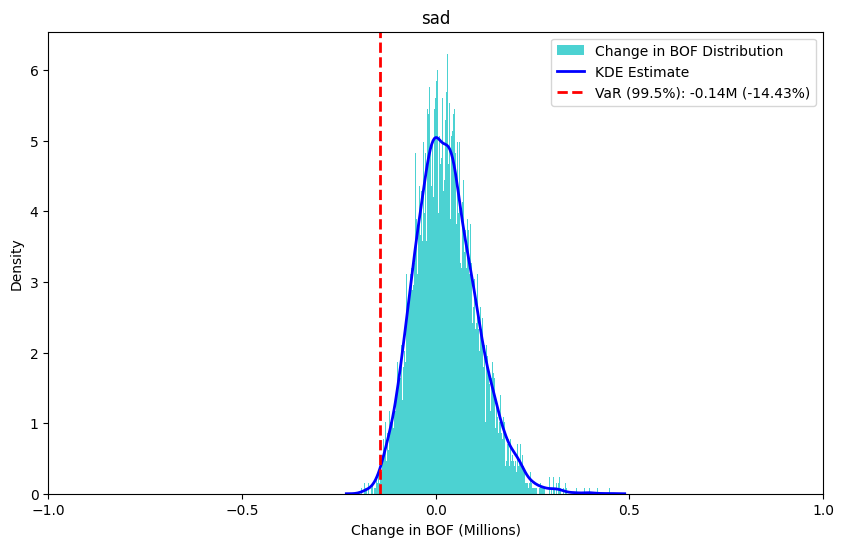

In [11]:
plot_bof_var(bof_change, scr, title="sad")